# Set up calculation details

In [ ]:
# Settings for Catechol ML PES generation


#import matplotlib
#matplotlib.use('Agg')

# Get default arguments for each script, then edit below
from esteem import drivers
from esteem import parallel
from esteem.tasks import qmd_trajectories, ml_training, ml_testing, ml_trajectories
from copy import deepcopy
from ase.units import AUT, fs

# Quantum Molecular Dynamics
parser = qmd_trajectories.make_parser()
qmd_args = parser.parse_args("")
qmd_traj_temps = {'ABCDEFGH': 300, 'IJKLMNOP': 500, 'QRSTUVWX': 700, 'YZ': 500}
qmd_args.func         = 'PBE'
qmd_args.basis        = '6-311G*'
qmd_args.target       = [0,1,2]
qmd_args.temp         = 300 # Kelvin - overridden in job array runs
qmd_args.nsnap        = 500
qmd_args.nequil       = 10
qmd_args.qmd_steps    = 100
qmd_args.qmd_timestep = 0.5*fs/AUT
qmd_args.ntraj        = 26
qmd_args.suffix       = 'qmd'
qmd_args.constraints  = None
qmd_traj_constraints  = {'Y': {'spring': 'bond 8 12 5.0 2.26'},
                         'Z': {'spring': 'bond 8 12 5.0 2.65'}}

# Resampling Trajectories at different levels of theory
retraj_args              = deepcopy(qmd_args)
retraj_args.basis        = '6-311++G**'
retraj_args.func         = 'PBE0'
retraj_args.input_suffix = 'training'
retraj_args.suffix       = 'retraj'
retraj_args.restart      = False

# Training
parser = ml_training.make_parser()
h3x10 = [10,10,10]; h3x15 = [15,15,15]; h3x20 = [20,20,20]
h4x10 = [10,10,10,10]; h4x15 = [15,15,15,15];  h4x20 = [20,20,20,20]
c1 = 6.5; c2 = 8.0
train_suffixes = [["3x10_R6.5",h3x10,c1,True],
                  ["3x10_R8.0",h3x10,c2,True],
                  ["3x15_R6.5",h3x15,c1,True],
                  ["3x15_R8.0",h3x15,c2,True],
                  ["3x20_R6.5",h3x20,c1,True],
                  ["3x20_R8.0",h3x20,c2,True],
                  ["4x10_R6.5",h4x10,c1,True],
                  ["4x10_R8.0",h4x10,c2,True],
                  ["4x15_R6.5",h4x15,c1,True],
                  ["4x15_R8.0",h4x15,c2,True],
                  ["4x20_R6.5",h4x20,c1,True],
                  ["4x20_R8.0",h4x20,c2,True]]
train_suffixes = [["NN1",None,10.0,False]]
i=0
train_args = parser.parse_args("")
train_args.trajname_suffix = "training"  # could change to "retraj" to train off resampled trajectory
train_args.suffix = train_suffixes[i][0]
train_args.hiddenlayers = train_suffixes[i][1]
train_args.cutoff = train_suffixes[i][2]
train_args.restart = train_suffixes[i][3]
train_args.force_coefficient = 0.25
train_args.overfit = 0.0
train_args.ntraj = 26
train_args.which_trajs = "ABCDEFIJKLMNQRSTUVYZ" # use 3/4 of each set, and extended bondlength set
train_args.cores = 1

# Testing 
parser = ml_testing.make_parser()
# use other halves of 300K, 500K and 700K sets for testing
test_trajs = {300: 'EFGH', 500: 'MNOP', 700: 'UVWX'}
test_args = parser.parse_args("")
test_args.trajname_suffix = "training"
test_args.prefix = "" #"fc0.25"
test_args.ntraj = 24
# Rest will be set in driver

from ase.constraints import Hookean, FixBondLengths

# ML Molecular Dynamics
parser = ml_trajectories.make_parser()
mltraj_args = parser.parse_args("")
mltraj_args.temp        = 300 # Kelvin
mltraj_args.md_timestep = 0.5*fs
mltraj_args.md_steps    = 1000
mltraj_args.ntraj       = 10
mltraj_args.which_trajs = 'ABCDEFGHIJ'
mltraj_args.nsnap       = 80
mltraj_args.nequil      = 1
mltraj_args.constraints = None
#FixBondLengths([[7,11]],bondlengths=[1.2])
# Hookean(a1=3, a2=atoms[3].position, rt=0.94, k=2.)


# Set up calculation packages

In [ ]:
import argparse
from esteem import drivers

# Set up NWChem Wrapper
from esteem.wrappers.nwchem import NWChemWrapper
qm_wrapper = NWChemWrapper()
qm_wrapper.setup()

# Set up ML Wrapper
from esteem.wrappers.amp import AMPWrapper
from esteem.wrappers.lammps import LAMMPSWrapper
from esteem.wrappers.physnet import PhysNetWrapper
#ml_wrapper = AMPWrapper()
#ml_wrapper = LAMMPSWrapper()
ml_wrapper = PhysNetWrapper()

# Find out fully-qualified domain name
import socket
host = socket.getfqdn()

# Set up queueing system
if "warwick.ac.uk" in host:
    # local SCRTP
    make_script = parallel.make_sbatch
    settings_serial = parallel.nanosim_1core
    settings_paral = parallel.nanosim_1node

elif "login1.orac.cluster" in host:
    # Orac SCRTP cluster
    make_script = parallel.make_sbatch
    settings_paral = parallel.orac_pnode
    
elif "cluster" in host:
    # HPCMidlands+ Athena
    make_script = parallel.make_sbatch
    settings_serial = parallel.athena_1node
    settings_paral = parallel.athena_1node



# Decide which script to run when invoked

In [ ]:
from esteem import drivers
import string
import shutil,os

from esteem.tasks import qmd_trajectories
def qmd_driver(args,qm_wrapper):

    # Make list of trajectories
    all_trajs = list(string.ascii_uppercase)[0:args.ntraj]

    # Determine if we are in a job array, in which case just run one trajectory
    task_id = parallel.get_array_task_id()
    if task_id is not None:
        args.which_trajs = all_trajs[task_id]
        # Check list of qmd_traj_temps to find appropriate temperature
        for key in qmd_traj_temps:
            if args.which_trajs in key:
                args.temp = qmd_traj_temps[key]
        # Check list of qmd_traj_constraints to find appropriate constraint
        for key in qmd_traj_constraints:
            if args.which_trajs in key:
                args.constraints = qmd_traj_constraints[key]
    print(args)
    qmd_trajectories.main(args,qm_wrapper)

from esteem.tasks import ml_training
def train_driver(args,ml_wrapper):

    # Determine if we are in a job array, in which case just run one trajectory
    task_id = parallel.get_array_task_id()
    if task_id is None:
        task_id = 0
    args.suffix = train_suffixes[task_id][0]
    args.hiddenlayers = train_suffixes[task_id][1]
    args.cutoff = train_suffixes[task_id][2]
    args.restart = train_suffixes[task_id][3]
    print(args)
    ml_training.main(args,ml_wrapper)

from esteem.tasks import ml_testing
def test_driver(args,ml_wrapper):

    # Determine if we are in a job array, in which case just run one trajectory
    task_id = parallel.get_array_task_id()
    if task_id is None:
        task_id = 0

    if args.target == 0 or args.target is None:
        seed_state_str = args.seed+"_gs"
    else:
        seed_state_str = args.seed+"_es"+str(args.target)

    suffix = train_suffixes[task_id][0]
    args.suffix = suffix
    if isinstance(ml_wrapper,AMPWrapper):
        calcfn = ml_wrapper.calc_filename(args.seed,args.target,prefix=args.prefix,suffix=suffix)
        calc_file = calcfn+ml_wrapper.calc_ext
        args.suffix = suffix+"_test"
        calcfn = ml_wrapper.calc_filename(args.seed,args.target,prefix=args.prefix,suffix=args.suffix)
        test_calc_file = calcfn+ml_wrapper.calc_ext
        test_calc_log = calcfn+ml_wrapper.log_ext
        if os.path.isfile(calc_file):
            print(f"Copying {calc_file} to {test_calc_file} for testing")
            shutil.copyfile(calc_file,test_calc_file)
        else:
            raise Exception("Calculator file does not exist: ",calc_file)
    
    for t in test_trajs:
        args.which_trajs = test_trajs[t]
        args.plotfile = seed_state_str + '_' + args.suffix + '_' + str(t) + '.png'
        print(args)
        ml_testing.main(args,ml_wrapper)
    
    if isinstance(ml_wrapper,AMPWrapper):
        if os.path.isfile(test_calc_log):
            os.remove(test_calc_log)

from esteem.tasks import ml_trajectories
def traj_driver(args,ml_wrapper):

    # Determine if we are in a job array, in which case just run one trajectory
    task_id = parallel.get_array_task_id()
    if task_id is None:
        task_id = 0
    args.calc_suffix = train_suffixes[task_id][0]
    
    for t in test_trajs:
        args.temp = t
        args.suffix = args.calc_suffix + '_mldyn_' + str(t)
        print(args)
        ml_trajectories.main(args,ml_wrapper)

def freq_driver(args,wrapper):

    # Determine if we are in a job array, in which case just run one trajectory
    task_id = parallel.get_array_task_id()
    if task_id is None:
        task_id = 0

    from ase.io import read
    model_opt = read(args.seed+".xyz")
        
    wrapper_is_ml = isinstance(wrapper,AMPWrapper) or isinstance(wrapper,PhysNetWrapper)
    wrapper_is_amp = isinstance(wrapper,AMPWrapper)

    if wrapper_is_ml:
        if wrapper_is_amp:
            # Find calculator suffix based on task_id
            suffix = train_suffixes[task_id][0]
            # Make a temporary copy of the calculator file
            calcfn = wrapper.calc_filename(args.seed,args.target,prefix='',suffix=suffix)
            calc_file = calcfn+wrapper.calc_ext
            args.calc_suffix = suffix+"_test"
            calcfn = wrapper.calc_filename(args.seed,args.target,prefix='',suffix=args.calc_suffix)
            test_calc_file = calcfn+wrapper.calc_ext
            test_calc_log = calcfn+wrapper.log_ext
            if os.path.isfile(calc_file):
                print(f"Copying {calc_file} to {test_calc_file} for testing")
                shutil.copyfile(calc_file,test_calc_file)
            else:
                raise Exception("Calculator file does not exist: ",calc_file)
        else:
            args.calc_suffix  = train_suffixes[task_id][0]
        # Set up calculator parameters dict
        calc_params = {'calc_seed': args.seed,
                       'calc_suffix': args.calc_suffix,
                       'calc_prefix': '',
                       'target': args.target}
    else:
        # QM Wrapper
        str1 = args.basis
        str2 = args.func
        calc_params = {}  # TODO
    print('calc_params', calc_params)
    # Tight-tolerance geometry optimisation first, before frequency calculation
    wrapper.geom_opt(model_opt,args.seed,calc_params,driver_tol='tight')
    print(f'Optimised positions')
    # Frequency calculation
    wrapper.freq(model_opt,args.seed,calc_params)
    
    # Cleanup
    if wrapper_is_amp:
        if os.path.isfile(test_calc_log):
            os.remove(test_calc_log)
        if os.path.isfile(test_calc_file):
            os.remove(test_calc_file)

def atom_energies_driver(args,wrapper):

    # Determine if we are in a job array, as this might be necessary for choosing
    # a calculator, for ML tasks
    task_id = parallel.get_array_task_id()
    if task_id is None:
        task_id = 0

    from ase.io import read, Trajectory
    from ase import Atoms
    model_opt = read(args.seed+".xyz")
        
    wrapper_is_ml = isinstance(wrapper,AMPWrapper)
    if wrapper_is_ml:
        # Find calculator suffix based on task_id
        suffix = train_suffixes[task_id][0]
        # Make a temporary copy of the calculator file
        calcfn = wrapper.calc_filename(args.seed,args.target,suffix)
        calc_file = calcfn+wrapper.calc_ext
        args.calc_suffix = suffix+"_test"
        calcfn = wrapper.calc_filename(args.seed,args.target,args.calc_suffix)
        test_calc_file = calcfn+wrapper.calc_ext
        test_calc_log = calcfn+wrapper.log_ext
        if os.path.isfile(calc_file):
            print(f"Copying {calc_file} to {test_calc_file} for testing")
            shutil.copyfile(calc_file,test_calc_file)
        else:
            raise Exception("Calculator file does not exist: ",calc_file)
        # Set up calculator parameters dict
        calc_params = {'calc_seed': args.seed,
                       'calc_suffix': args.calc_suffix,
                       'calc_prefix': '',
                       'target': args.target}
    else:
        # QM Wrapper
        str1 = args.basis
        str2 = args.func
        calc_params = {'basis':args.basis,'func':args.func,'target':None}  # TODO

    atom_list = set(model_opt.symbols)
    atom_energies = {}
    atom_traj = Trajectory(f'{args.seed}_atoms.traj','w')
    for atom in atom_list:
        atom_model = Atoms(atom)
        if atom=='H':
            spin=0.5
        if atom=='O':
            spin=2
        if atom=='C':
            spin=0
        if wrapper_is_ml:
            atom_energies[atom],calc = wrapper.singlepoint(atom_model,
                f'{args.seed}',calc_params)
        else:
            atom_energies[atom],calc = wrapper.singlepoint(atom_model,
                f'{args.seed}_{atom}',calc_params,spin=spin)
        atom_traj.write(atom_model)
        print(f'atom_energies[{atom}] = {atom_energies[atom]}')
    atom_traj.close()

import sys
if "ipykernel_launcher.py" in sys.argv[0]:
    mltraj_args.seed = "cate"
    freq_driver(mltraj_args,ml_wrapper)
    raise Exception("Skipping main routine as notebook environment detected")

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description=f'DFT+ML driver script')
    parser.add_argument('task',default='scripts')
    parser.add_argument('seed',default='cate')
    parser.add_argument('target',default=0,type=int)
    args = parser.parse_args()
    if ('scripts' in args.task.split()):
        for task in ['qmd','retraj','train','qmfreq']:
            make_script(seed=args.seed,target=args.target,task=task,**settings_paral)
        for task in ['test','mltraj','mlfreq']:
            make_script(seed=args.seed,target=args.target,task=task,**settings_serial)
    if int(args.target)==0:
        args.target = None
    if ('qmd' in args.task.split()):
        qmd_args.seed = args.seed
        qmd_driver(qmd_args,qm_wrapper)
    if ('retraj' in args.task.split()):
        retraj_args.seed = args.seed
        retraj_args.target = args.target
        qmd_driver(retraj_args,qm_wrapper)     
    if ('train' in args.task.split()):
        train_args.seed = args.seed
        train_args.target = args.target
        train_driver(train_args,ml_wrapper)
    if ('test' in args.task.split()):
        test_args.seed = args.seed
        test_args.target = args.target
        test_driver(test_args,ml_wrapper)
    if ('mltraj' in args.task.split()):
        mltraj_args.seed = args.seed
        mltraj_args.target = args.target
        traj_driver(mltraj_args,ml_wrapper)
    if ('mlfreq' in args.task.split()):
        mltraj_args.seed = args.seed
        mltraj_args.target = args.target
        freq_driver(mltraj_args,ml_wrapper)
    if ('qmfreq' in args.task.split()):
        qmd_args.seed = args.seed
        qmd_args.target = args.target
        freq_driver(qmd_args,qm_wrapper)
    if ('spectra' in args.task.split()):
        drivers.spectra_main(args.seed,spectra_args)

exit()

# Interactive Analysis

In [ ]:
from ase.io import Trajectory
from esteem.trajectories import compare_traj_to_traj
import matplotlib.pyplot as plt
import numpy as np
full_diff=[]
for s in 'ABCDEFGH':
    st='es1'
    seed_state_str='cate_'+st
    tr='retraj'
    xtrajfile = seed_state_str + '_' + s + '_' + tr + '.traj'
    st='gs'
    seed_state_str='cate_'+st
    ytrajfile = seed_state_str + '_' + s + '_' + tr + '.traj'
    print(xtrajfile,ytrajfile)
    trajx=Trajectory(xtrajfile)
    trajy=Trajectory(ytrajfile)
    rms_e_err,max_e_err,rms_fd_err,max_fd_err,e_x,e_y,rms_fd = compare_traj_to_traj(trajx,trajy,plot_file=None)
    #qmd_trajectories.plot_diff(e_x,e_y,rms_fd,align_axes=False)
    e_diff = np.array(e_x)-np.array(e_y)
    full_diff += e_diff.tolist()
print(np.array(full_diff))
plt.plot(full_diff)

In [ ]:
from ase.io import Trajectory
traj500=Trajectory("cate_gs_W_retraj.traj")
from ase.visualize import view

view(traj500,viewer='nglview')

In [ ]:
t0=traj500[0]
print(t0.get_potential_energy())

view(traj500,viewer='ngl')

In [ ]:
import numpy as np

dat = np.loadtxt("cate_gs4x20_R8.0-log.txt_filt",usecols=(0,2,3,5,7,9))

import matplotlib.pyplot as plt
plt.yscale('log')
plt.axhline(0.02)
plt.xlim(0,10000)

from scipy.optimize import curve_fit

def f(x,a,b):
    return b*np.exp(-a*x)

(a,b),(c,d) = curve_fit(f,dat[4000:,0],dat[4000:,4],p0=(0.00017,0.11))
plt.plot(dat[:,0],dat[:,4])
fit = np.zeros_like(dat[:,0])
#a,b = (0.00017,0.11)
for i,d in enumerate(dat[:,0]):
    fit[i] = f(d,a,b)

plt.plot(dat[:,0],dat[:,4])
plt.plot(dat[:,0],fit[:])


In [ ]:
import numpy as np

dat = []
print()
for s in [c[0] for c in train_suffixes]:
    print(s)
    fn = "cate_gs"+str(s)+"-log.txt_filt"
    print(fn)
    dat.append(np.loadtxt(fn,usecols=(0,2,3,5,7,9)))

import matplotlib.pyplot as plt
plt.yscale('log')
plt.axhline(0.02)
plt.xlim(0,5000)

from scipy.optimize import curve_fit

def f(x,a,b):
    return b*np.exp(-a*x)

(a,b),(c,d) = curve_fit(f,dat[0][:,0],dat[0][:,4],p0=(0.1,4))
plt.plot(dat[0][:,0],dat[0][:,4])
fit = np.zeros_like(dat[0][:,0])
for i,d in enumerate(dat[0][:,0]):
    fit[i] = f(d,a,b)
plt.plot(dat[0][:,0],fit[:])


In [ ]:
from ase.io import Trajectory
from esteem.wrappers.amp import load_AMP
from ase.units import Hartree, Bohr
calc = load_AMP("cate_es1","4x15_R8.0")
traj = Trajectory("cate_es1_A_retraj.traj")
print(Hartree/Bohr)
frame1 = traj[10]
frame2 = traj[29]
frame_curr = frame1.copy()
N=10
for i in range(0,N):
    f = i/N
    pos = frame1.get_positions()*(1-f) + frame2.get_positions()*f
    frame_curr.set_positions(pos)
e1,f1=frame1.get_potential_energy(),frame1.get_forces()
e2,f2=frame2.get_potential_energy(),frame2.get_forces()
#f3 = calc.calculate_numerical_forces(frame)
print(e1,e2,f1[1],f2[1])

In [ ]:
from ase.io import read,Trajectory
outtraj=Trajectory("tmp.traj",'a')
for i in range(0,80):
    fname = f"cate_es1/1-{i:03}.xyz"
    outtraj.write(read(fname))
outtraj.close()
intraj=Trajectory("tmp.traj")
from ase.visualize import view
#view(intraj,viewer='ngl')
at=intraj[-1]
del at[[7,11]]
view(at,viewer='ngl')

In [ ]:
from esteem.tasks import ml_trajectories
import os
from copy import deepcopy
os.chdir('/storage/nanosim/cate_qmd')
task_id=2; t=300
mlargs = deepcopy(mltraj_args)
mltraj_args.seed = 'cate'; mltraj_args.target=1
mltraj_args.calc_suffix = train_suffixes[task_id][0]
print(mltraj_args.calc_suffix)
mltraj_args.suffix = mltraj_args.calc_suffix + '_mldyn_' + str(t)
!pwd
ml_trajectories.main(mltraj_args,ml_wrapper)

#from ase.optimize import BFGS
#opt = BFGS(cate_gs, trajectory='opt_test.traj')
#opt.run()

In [ ]:
os.chdir('/storage/nanosim/cate_qmd')
traj=Trajectory("cate_es1_A_3x15_R6.5_mldyn_300.traj")
from ase.visualize import view
view(traj,viewer='ngl')
#for t in traj:
#    print(t.get_distance(7,11))

In [16]:
from ase.io import read
from ase.io.trajectory import Trajectory
from ase.visualize import view,ngl

t = Trajectory("cate_es1_A_qmd.traj")

def show_forces(atoms,forces,scale=3,color=[0.2,0.2,0.2],size=0.2,w=500,h=500):
    view = ngl.view_ngl(atoms, w=w, h=h).view
    view.add_ball_and_stick()
    print(type(view))
    for i,atom in enumerate(atoms):
        p1=atom.position.tolist()
        p2=(atom.position+forces[i]*scale).tolist()
        view.shape.add_arrow(p1,p2,color,size)
    return view

show_forces(t[5],t[5].get_forces(),scale=1)

<class 'nglview.widget.NGLWidget'>


NGLWidget()

In [ ]:
!pwd
from ase.io import Trajectory, read
from ase.optimize import LBFGS
from copy import deepcopy

cate = read('cate.xyz')
cate_opt = read('cate_gs_opt.xyz')

from amp import Amp
# Set Calc
amp_calcs = {}
amp_calcs['GS'] = Amp.load('cate_gs_4x15_R6.5.amp')
#amp_calcs['ES1'] = Amp.load('cate_es1_4x15_R8.0.amp')
#amp_calcs['ES2'] = Amp.load('AMP_calculators/cate_train/cate_es2_A-D_011.amp')
#amp_calcs['GS2'] = Amp.load('AMP_calculators/cate_train/cate_gs_A-D_002.amp')
cates = {}

for state, calc in amp_calcs.items():
    cate_lbfgs_opt = deepcopy(cate)
    cate_lbfgs_opt.set_calculator(calc)
    print(cate_lbfgs_opt.get_calculator())
    trajectory = 'lbfgs' + state + '.pickl'
    restart = None #'lbfgs_' + state + '.pickl'

    dyn = LBFGS(atoms=cate_lbfgs_opt, trajectory=trajectory, restart=restart)
    dyn.run(fmax=0.001)

    cates[state] = cate_lbfgs_opt

In [ ]:
mltraj_args.seed = "cate"
traj_driver(mltraj_args,ml_wrapper)

In [ ]:
import os
os.chdir("/storage/nanosim/cate_qmd/3x10_R6.5_mldyn_500_equil")

from ase.io import lammpsrun
from glob import glob

files = glob("*.bin")
print(files)
file = files[0]
atoms = lammpsrun.read_lammps_dump(file,index=slice(0,10999))
for a in atoms:
    a.symbols = "C6O2H6"
print(type(atoms))
from ase.visualize import view

view(atoms,viewer='nglview')



In [ ]:
lammpsrun.read_lammps_dump_binary??

In [ ]:
atoms[-3].get_positions()

In [ ]:
import os
os.chdir("/storage/nanosim/cate_qmd/NN1_mldyn_300_snaps")

from ase.io import read, Trajectory
from ase.visualize import view
from esteem.trajectories import get_trajectory_list
ntraj = 3
seed_state_str = "cate_gs"
calc_suffix="NN1"
temp = 300
chars = get_trajectory_list(ntraj)
mdsteps = 1000
nsnaps = 80
mu_t = np.zeros((ntraj,nsnaps*mdsteps,3))
trajname = chars[0]
for i,trajname in enumerate(chars):
    k=0
    for j in range(0,nsnaps):
        file = f'{seed_state_str}_{trajname}_{calc_suffix}_mldyn_{temp}_snaps{j:03}.traj'
        traj = Trajectory(file)
        print(file)
        for f in traj[1:]:
            mu_t[i,k] = f.get_dipole_moment()
            k = k+1

#os.chdir("/storage/nanosim/cate_qmd/")

In [1]:
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib
# The following installs jcamp:
# pip install --user jcamp
import os
os.chdir("/storage/nanosim/cate_qmd/")

import jcamp
jcamp_dict = jcamp.JCAMP_reader("120-80-9-IR.jdx")
spec = np.loadtxt('cate_gs_NN1_ir_spectrum.dat')
#plt.plot(jcamp_dict['x'], jcamp_dict['y'],label='NIST webbook')
#plt.show()

1001


<IPython.core.display.Javascript object>


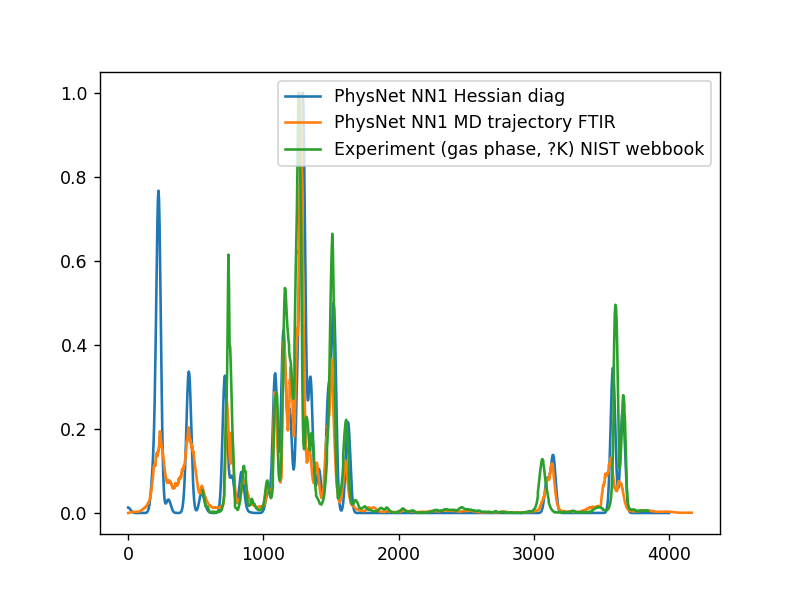

In [5]:
seed_state_str = "cate_gs"
calc_suffix="NN1"
ntraj = 10
nsnaps = 80
mdsteps = 1000
temp = 500
traj_suffix = f"{calc_suffix}_mldyn_{temp}_snaps"

# 40000fs trajectories, 0.5fs timestep corresponds to 0.83391 cm^-1 spacing, up to 66712.81904 cm^-1
from ase import units
freq_scale_fac = (1e15/units._c/100)
dt = 0.5
sigma=20

from esteem.tasks.ml_trajectories import load_trajectory_dipole, calculate_ir_spectrum

#mu_t = load_trajectory_dipole(seed_state_str,traj_suffix,ntraj,nsnaps,mdsteps)

#mu_dot_tilde_av_mag_conv, omega = calculate_ir_spectrum(mu_t,dt,freq_scale_fac,sigma)

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

# Plot results
print(len(spec[:,2]))
comp = np.array([10**-5]*len(spec[:,2]))
spec2 = np.maximum(1-spec[:,2],comp)
plt.plot(spec[:,0],spec2,label='PhysNet NN1 Hessian diag')
plt.plot(omega[:5000],mu_dot_tilde_av_mag_conv[:5000]/np.max(mu_dot_tilde_av_mag_conv[:5000]),
         label='PhysNet NN1 MD trajectory FTIR')
plt.plot(jcamp_dict['x'], jcamp_dict['y']/np.max(jcamp_dict['y']),label='Experiment (gas phase, ?K) NIST webbook')
#plt.yscale('log')
plt.legend()
plt.show()